# Подгрузка пакетов и данных

In [1]:
cd ..

/Users/n.barsukov/WebstormProjects/ml-bug-detector


In [2]:
import pandas as pd
import numpy as np
import json
from tqdm.notebook import tqdm

from gensim.models.word2vec import Word2Vec

from shared.consts import FUNCTIONS_JSON_PROPERTIES_NAMES, PATH_TO_FUNCTIONS_STORAGE_JSON, PATH_TO_WORD2VEC_MODEL

Загрузим уже построенную модель Word2Vec

In [3]:
word2VecModel = Word2Vec.load(PATH_TO_WORD2VEC_MODEL)

Загрузим JSON, в котором мы сложили названия функций (и названия их арггументов)

In [4]:
functions_storage_dictionary = json.load(open(PATH_TO_FUNCTIONS_STORAGE_JSON))

# Отделение объявления функций от их использования

Функции с одним и тем же названием могут быть объявлены по-разному, поэтому задания функций будут склдываться в словарь по принципу:

Имя репозитория + имя функции

In [5]:
SEPARATOR_REPO_FUNCNAME = '___'

def get_key_in_func_creation_dict(func_name, file_path):
    paths_segments = file_path.split('/')
    
    if (len(paths_segments) > 2):
        return paths_segments[1] + SEPARATOR_REPO_FUNCNAME + func_name
    else:
        return func_name
    
def get_func_name_from_key(key_in_func_creation_dict):
    return key_in_func_creation_dict.split(SEPARATOR_REPO_FUNCNAME)[-1]

In [6]:
def find_all_functions_creations(func_storage_dic):
    func_creation_dic = {}
    
    for filePath in func_storage_dic.keys():
        for function in func_storage_dic[filePath]:
            if (
                function[FUNCTIONS_JSON_PROPERTIES_NAMES.FUNC_TYPE] == 'FunctionDeclaration' or
                function[FUNCTIONS_JSON_PROPERTIES_NAMES.FUNC_TYPE] == 'FunctionExpression'
               ):
                func_name = function[FUNCTIONS_JSON_PROPERTIES_NAMES.FUNC_NAME]
                func_creation_dict_key = get_key_in_func_creation_dict(func_name, filePath)
                if func_creation_dict_key in func_creation_dic:
                    pass
                    #print(func_creation_dict_key, 'уже есть в словаре')
                func_creation_dic[func_creation_dict_key] = {
                    f"{FUNCTIONS_JSON_PROPERTIES_NAMES.ARGS_NAMES}" : function[FUNCTIONS_JSON_PROPERTIES_NAMES.ARGS_NAMES],
                    f"{FUNCTIONS_JSON_PROPERTIES_NAMES.FILE_PATH}": filePath
                }
    
    return func_creation_dic

In [7]:
func_creation_dic = find_all_functions_creations(functions_storage_dictionary)

А теперь находим все ВЫЗОВЫ функций и смотрим, насколько их аргументы отличны объявления функции

In [82]:
def find_all_func_executions(func_storage_dic, func_creation_dic, onlyInDictionary = True):
    func_exec_storage = []
    
    for filePath in func_storage_dic.keys():
        for function in func_storage_dic[filePath]:
            func_name = function[FUNCTIONS_JSON_PROPERTIES_NAMES.FUNC_NAME]
            func_creation_dict_key = get_key_in_func_creation_dict(func_name, filePath)
            
            if (
                function[FUNCTIONS_JSON_PROPERTIES_NAMES.FUNC_TYPE] == 'CallExpression' and # должна быть вызовом функции
                len(function[FUNCTIONS_JSON_PROPERTIES_NAMES.ARGS_NAMES]) > 0 and # должна иметь хоть один аргумент
                (func_creation_dict_key in func_creation_dic or not onlyInDictionary)# должна быть в нашем словаре
            ):
                function[FUNCTIONS_JSON_PROPERTIES_NAMES.FILE_PATH] = filePath
                func_exec_storage.append(function)
    
    return func_exec_storage

In [83]:
func_exec_storage = find_all_func_executions(functions_storage_dictionary, func_creation_dic)

In [84]:
print('Размер словаря с объявлениями функций: ', len(func_creation_dic))
print('Размер массива с вызовами функций: ', len(func_exec_storage))

Размер словаря с объявлениями функций:  18626
Размер массива с вызовами функций:  2730


Словарь с объявлениями функций - словарь, в котором ключ - название функции, а значение – массив с названиями переданных аргументов.

Пример: функция с названием **confirmDelete**

In [11]:
func_creation_dic[get_key_in_func_creation_dict('confirmDelete', 'scripts/Block8/PHPCI/public/assets/js/phpci.js')]

{'argumentsNames': ['url', 'subject', 'reloadAfter'],
 'filePath': 'scripts/Block8/PHPCI/public/assets/js/phpci.js'}

Массив с вызовами функций состоит из словарей следующего формата

In [12]:
list(filter(lambda func_exec: func_exec[FUNCTIONS_JSON_PROPERTIES_NAMES.FUNC_NAME] == 'confirmDelete',func_exec_storage))

[]

# Алгоритм проверки схожести аргументов

In [13]:
def checkIfWordInWord2VecDict(word, word2VecVocabulary = word2VecModel.wv):
    return word in word2VecVocabulary

def get_args_similarity(exec_func_name, exec_func_args_names, func_path, func_dict, word2VecModel):
    """Определяет схожесть названий аргументов в вызове функции с названиями аргументов в объявлении функции"""
    args_similarity = []
    
    func_in_func_creation_dic_key = get_key_in_func_creation_dict(exec_func_name, func_path)
    
    for argIndex in range(len(exec_func_args_names)):
        
        if argIndex > len(func_dict[func_in_func_creation_dic_key][FUNCTIONS_JSON_PROPERTIES_NAMES.ARGS_NAMES]) - 1:
            args_similarity.append(None)
            continue
        
        exec_arg = exec_func_args_names[argIndex]
        create_arg = func_dict[get_key_in_func_creation_dict(exec_func_name, func_path)][FUNCTIONS_JSON_PROPERTIES_NAMES.ARGS_NAMES][argIndex]
        
        if (checkIfWordInWord2VecDict(exec_arg) and checkIfWordInWord2VecDict(create_arg)):
            args_similarity.append(word2VecModel.wv.similarity(exec_arg, create_arg))
        else:
            args_similarity.append(None)
        
    return args_similarity

Посмотрим, как это работает на примере

In [14]:
example_func_exec = list(filter(lambda func: func[FUNCTIONS_JSON_PROPERTIES_NAMES.FUNC_NAME].endswith('updateLine'), func_exec_storage))
example_func_exec = example_func_exec[0]

func_name = example_func_exec[FUNCTIONS_JSON_PROPERTIES_NAMES.FUNC_NAME]
func_path = example_func_exec[FUNCTIONS_JSON_PROPERTIES_NAMES.FILE_PATH]
args_names = example_func_exec[FUNCTIONS_JSON_PROPERTIES_NAMES.ARGS_NAMES]

print('Вызов функции:', func_name, 'c аргументами', args_names)
func_in_func_creation_dic_key = get_key_in_func_creation_dict(func_name, example_func_exec[FUNCTIONS_JSON_PROPERTIES_NAMES.FILE_PATH])
print('Функция же была объявлена с словаре с аргументами:', func_creation_dic[func_in_func_creation_dic_key][FUNCTIONS_JSON_PROPERTIES_NAMES.ARGS_NAMES])

get_args_similarity(func_name, args_names, func_path, func_creation_dic, word2VecModel)

Вызов функции: updateLine c аргументами ['lastLine', 'lastSpans', 'estimateHeight']
Функция же была объявлена с словаре с аргументами: ['line', 'text', 'markedSpans', 'estimateHeight']


[0.44814897, -0.022563308, 0.33035174]

# Реализация на всем массиве вызовов функции

Идея максимально проста. Проходим по массиву вызовов функции.

- По названию функции определяем в словаре с объявлениями функций, с какими названиями аргументов была объявлена эта функция
- Для каждой пары аргументов (название аргумента в момент вызовы функции и название аргумента в момент объявление функции) считаем близость их названий в векторной форме с помощью уже построенной модели word2Vec (это будет значение 0 до 1)
- Если эта схожесть меньше заданного порога (threshold), то выбрасываем предупреждение пользователю

### Threshold

In [15]:
MIN_SIMILARITY_THRESHOLD = 0.1

Порог не должен быть большой, потому что модели важно достичь высокого precision, а не recall.

Если наш алгоритм будет часто беспокоить пользователя по пустякам, предупреждая об ошибках там, где их нет (false positive), то нашим алгоритмом просто никто не будет пользоваться. Нужно беспокоить программиста только прям в самых вероятных случаях наличия ошибки. Ведь программисты люди ленивые и занятые... 

In [16]:
# for func_exec in func_exec_storage:
#     func_name = func_exec[FUNCTIONS_JSON_PROPERTIES_NAMES.FUNC_NAME]
#     args_names = func_exec[FUNCTIONS_JSON_PROPERTIES_NAMES.ARGS_NAMES]
#     func_path = func_exec[FUNCTIONS_JSON_PROPERTIES_NAMES.FILE_PATH]
    
#     args_similarities = get_args_similarity(func_name, args_names, func_path, func_creation_dic, word2VecModel)
#     is_below_threshold_args_similarities = list(map(lambda x: x and x < MIN_SIMILARITY_THRESHOLD, args_similarities))
    
#     if (any(is_below_threshold_args_similarities)):
#         print('В файле', func_path, 'проверь:')
#         print('Была вызвана функция', func_name, 'с аргументами', args_names)
#         print('Но вот объявлена функция была со следующими аргументами:')
#         print(func_creation_dic[get_key_in_func_creation_dict(func_name, func_path)][FUNCTIONS_JSON_PROPERTIES_NAMES.ARGS_NAMES])
#         print(args_similarities)
#         print('_____________')

## Эксперименты с моделями

### Трансформируем данные

Оставим только функции, у которых 2 аргумента

In [17]:
func_creation_dic_2_args = dict(
    filter(lambda elem: len(elem[1][FUNCTIONS_JSON_PROPERTIES_NAMES.ARGS_NAMES]) == 2, func_creation_dic.items())
)

In [18]:
class TWO_ARGS_FUNC_COLUMNS:
    FIRST_ARG = 'arg1'
    SECOND_ARG = 'arg2'
    FUNC_NAME = 'funcName'
    TARGET = 'isBuggy'  # В верном ли порядке расставлены аргументы в функции

In [19]:
two_args_funcs = pd.DataFrame.from_dict(func_creation_dic_2_args, orient='index')
two_args_funcs[[TWO_ARGS_FUNC_COLUMNS.FIRST_ARG, TWO_ARGS_FUNC_COLUMNS.SECOND_ARG]] = pd.DataFrame(
    two_args_funcs.argumentsNames.tolist(), index=two_args_funcs.index
)

two_args_funcs[TWO_ARGS_FUNC_COLUMNS.FUNC_NAME] = list(
    map(lambda rowName: get_func_name_from_key(rowName), two_args_funcs.index)
)
two_args_funcs.drop(['argumentsNames', 'filePath'], axis='columns', inplace=True)
two_args_funcs[TWO_ARGS_FUNC_COLUMNS.TARGET] = 0

two_args_funcs.reset_index(inplace=True, drop=True)

print('Количество строк:', len(two_args_funcs))
two_args_funcs.head(3)

Количество строк: 3701


,arg1,arg2,funcName,isBuggy
0,stringerName,alertData,onAlert,0
1,child,parent,extend,0
2,el,highlighter,doHighlight,0


Меняем местами аргументами и добавляем эти строчки как isBuggy = 1

(то есть получим 50% одного класса и 50% другого класса)

In [20]:
buggy_code_rows = []

for rowIndex in tqdm(range(len(two_args_funcs))):
    new_row = {
        TWO_ARGS_FUNC_COLUMNS.FUNC_NAME: two_args_funcs.loc[rowIndex, TWO_ARGS_FUNC_COLUMNS.FUNC_NAME],
        TWO_ARGS_FUNC_COLUMNS.FIRST_ARG: two_args_funcs.loc[rowIndex, TWO_ARGS_FUNC_COLUMNS.SECOND_ARG],
        TWO_ARGS_FUNC_COLUMNS.SECOND_ARG: two_args_funcs.loc[rowIndex, TWO_ARGS_FUNC_COLUMNS.FIRST_ARG],
        TWO_ARGS_FUNC_COLUMNS.TARGET: 1
    }
    buggy_code_rows.append(new_row)

two_args_funcs = two_args_funcs.append(pd.DataFrame(buggy_code_rows)).reset_index(drop=True)

In [21]:
print('Количество строк:', len(two_args_funcs))
two_args_funcs.tail(3)

Количество строк: 7402


,arg1,arg2,funcName,isBuggy
7399,metric,paramGroup,getParamValueFromPath,1
7400,metric,paramGroup,applyRegexToName,1
7401,data,target,renderExtendedGraph,1


Теперь заменяем слова на их векторное представление из word2Vec.

Если например, каждое слово представлено в модели word2Vec как вектор из 300 значений, то название функции + 2 аргумента + 1 целевая перееменная (isBuggy) = 901 переменная в датасете

In [22]:
def replace_string_column_with_vectors(pd_df, columnName, word2VecVocabulary = word2VecModel.wv):
    DEFAULT_VALUE_IF_NOT_EXITS_IN_WORD2VEC = '0'
    
    vector_size = len(word2VecVocabulary[DEFAULT_VALUE_IF_NOT_EXITS_IN_WORD2VEC])
    
    future_columns_names = []
    
    vectorized_df = pd.DataFrame()
    
    for i in range(vector_size):
        future_columns_names.append(columnName + str(i))
    
    for rowIndex in tqdm(range(len(pd_df))):
        word = pd_df.loc[rowIndex, columnName]
        
        if not checkIfWordInWord2VecDict(word, word2VecVocabulary):
            #word = DEFAULT_VALUE_IF_NOT_EXITS_IN_WORD2VEC
            newColumnsDf = pd.DataFrame(np.array([None] * vector_size).reshape(-1, vector_size), columns = future_columns_names)
        else:
            newColumnsDf = pd.DataFrame(
                word2VecVocabulary[word].reshape(-1, len(word2VecVocabulary[word])), columns = future_columns_names
            )
   
        vectorized_df = vectorized_df.append(newColumnsDf)
    
    return pd.concat([pd_df, vectorized_df.reset_index(drop=True)], axis=1)

In [23]:
two_args_funcs = replace_string_column_with_vectors(two_args_funcs, TWO_ARGS_FUNC_COLUMNS.FIRST_ARG, word2VecModel.wv)
two_args_funcs = replace_string_column_with_vectors(two_args_funcs, TWO_ARGS_FUNC_COLUMNS.SECOND_ARG, word2VecModel.wv)
two_args_funcs = replace_string_column_with_vectors(two_args_funcs, TWO_ARGS_FUNC_COLUMNS.FUNC_NAME, word2VecModel.wv)

two_args_funcs = two_args_funcs.drop(
    [TWO_ARGS_FUNC_COLUMNS.FIRST_ARG, TWO_ARGS_FUNC_COLUMNS.SECOND_ARG, TWO_ARGS_FUNC_COLUMNS.FUNC_NAME],
    axis=1
)

In [24]:
two_args_funcs = two_args_funcs.dropna().reset_index(drop=True)

In [74]:
len(two_args_funcs)

2656

### Обучаем

Кормим это дело модели

In [25]:
y = np.array(two_args_funcs[TWO_ARGS_FUNC_COLUMNS.TARGET])

X = two_args_funcs.drop(TWO_ARGS_FUNC_COLUMNS.TARGET, axis = 1)

In [126]:
from sklearn.naive_bayes import GaussianNB

nbayes = GaussianNB()

nbayes.fit(X, y)

GaussianNB(priors=None, var_smoothing=1e-09)

In [104]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier()

knn.fit(X, y)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

In [26]:
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics

rf = RandomForestClassifier(n_estimators = 1000, random_state = 27)

rf.fit(X, y);

### Проверяем на обучающей

In [27]:
y_train_pred = rf.predict(X)
print('accuracy:', metrics.accuracy_score(y, y_train_pred))
print('recall:', metrics.recall_score(y, y_train_pred))
print('precision:', metrics.precision_score(y, y_train_pred))

accuracy: 1.0
recall: 1.0
precision: 1.0


### Проверяем на тестовой выборке

Формируем тестовую выборку из массива с вызовами функциями

Вновь фильтруем только функции с 2 аргументами

In [87]:
func_exec_storage_all = find_all_func_executions(functions_storage_dictionary, func_creation_dic, False)

func_exec_storage_2_args = list(filter(lambda func: len(func[FUNCTIONS_JSON_PROPERTIES_NAMES.ARGS_NAMES]) == 2, func_exec_storage_all))

превращаем в датафрейм

In [88]:
func_exec_2_args_df = pd.DataFrame(func_exec_storage_2_args)

func_exec_2_args_df = func_exec_2_args_df.rename(
    columns={FUNCTIONS_JSON_PROPERTIES_NAMES.FUNC_NAME: TWO_ARGS_FUNC_COLUMNS.FUNC_NAME}
)

func_exec_2_args_df[[TWO_ARGS_FUNC_COLUMNS.FIRST_ARG, TWO_ARGS_FUNC_COLUMNS.SECOND_ARG]] = pd.DataFrame(
    func_exec_2_args_df[FUNCTIONS_JSON_PROPERTIES_NAMES.ARGS_NAMES].tolist(), index=func_exec_2_args_df.index
)

func_exec_2_args_df = func_exec_2_args_df.drop([
    FUNCTIONS_JSON_PROPERTIES_NAMES.FUNC_TYPE,
    FUNCTIONS_JSON_PROPERTIES_NAMES.ARGS_NAMES
], axis='columns')

In [89]:
func_exec_2_args_df.head(3)

,funcName,filePath,arg1,arg2
0,sendAlert,scripts/BBC-News-Labs/datastringer/datastringe...,stringerName,alertData
1,insertBefore,scripts/BaiduFE/Tangram-tools/codesearch/stati...,div,el
2,,scripts/BeamNG/ui/js/spectrum.js,window,jQuery


векторизуем перемененные 

In [90]:
func_exec_2_args_df = replace_string_column_with_vectors(func_exec_2_args_df, TWO_ARGS_FUNC_COLUMNS.FIRST_ARG, word2VecModel.wv)
func_exec_2_args_df = replace_string_column_with_vectors(func_exec_2_args_df, TWO_ARGS_FUNC_COLUMNS.SECOND_ARG, word2VecModel.wv)
func_exec_2_args_df = replace_string_column_with_vectors(func_exec_2_args_df, TWO_ARGS_FUNC_COLUMNS.FUNC_NAME, word2VecModel.wv)

func_exec_2_args_df = func_exec_2_args_df.dropna()

INFO_COLUMNS = [FUNCTIONS_JSON_PROPERTIES_NAMES.FILE_PATH, TWO_ARGS_FUNC_COLUMNS.FIRST_ARG, TWO_ARGS_FUNC_COLUMNS.SECOND_ARG, TWO_ARGS_FUNC_COLUMNS.FUNC_NAME]

test_2_args_exec_df = func_exec_2_args_df.drop(
    INFO_COLUMNS,
    axis='columns'
)

func_exec_2_args_df = func_exec_2_args_df[INFO_COLUMNS]

In [91]:
func_exec_2_args_df.head(3)

,filePath,arg1,arg2,funcName
1,scripts/BaiduFE/Tangram-tools/codesearch/stati...,div,el,insertBefore
3,scripts/Benvie/continuum/engine/builtins/@json.js,stack,value,add
4,scripts/Benvie/continuum/experimental/op-codeg...,NumericType,Type,inherit


In [92]:
test_2_args_exec_df.head(3)

,arg10,arg11,arg12,arg13,arg14,arg15,arg16,arg17,arg18,arg19,...,funcName290,funcName291,funcName292,funcName293,funcName294,funcName295,funcName296,funcName297,funcName298,funcName299
1,-0.761421,0.671357,0.509182,-0.409509,-0.474155,0.745702,-0.859645,0.703685,-0.286042,1.654904,...,0.788759,-0.556789,0.837385,-0.713586,0.026411,1.864064,0.029031,0.322394,0.745573,-1.685836
3,-0.267572,0.842256,0.269688,1.924251,0.406795,-0.874226,0.630784,0.207103,1.555780,1.127240,...,-0.565680,0.382932,0.059636,-0.445982,-1.235685,0.717393,1.293220,0.305484,1.687727,-0.568059
4,-0.039585,0.045312,0.037702,-0.044954,0.028094,-0.108297,-0.050363,-0.040153,-0.070570,-0.048161,...,-0.064009,1.693059,0.501640,0.338483,-0.706274,0.427245,0.557781,-0.273727,0.410294,-1.192103


In [93]:
PRED_PROB_COLUMN = TWO_ARGS_FUNC_COLUMNS.TARGET + '_pred'

func_exec_2_args_df[PRED_PROB_COLUMN] = list(map(lambda x: x[1], rf.predict_proba(test_2_args_exec_df) ))

In [105]:
PRED_PROB_COLUMN = TWO_ARGS_FUNC_COLUMNS.TARGET + '_pred'

func_exec_2_args_df[PRED_PROB_COLUMN] = list(map(lambda x: x[1], knn.predict_proba(test_2_args_exec_df) ))

In [127]:
PRED_PROB_COLUMN = TWO_ARGS_FUNC_COLUMNS.TARGET + '_pred'

func_exec_2_args_df[PRED_PROB_COLUMN] = list(map(lambda x: x[1], nbayes.predict_proba(test_2_args_exec_df) ))


Посмотрим, как распределены вероятности уверенности модели, что конкретный вызов функции - баг.

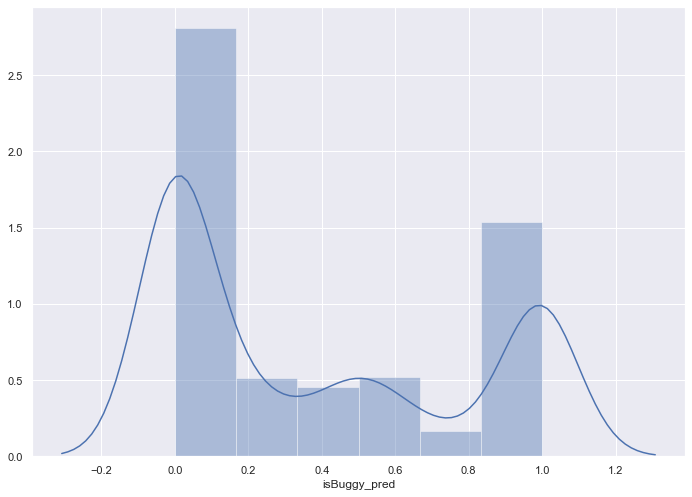

In [128]:
import seaborn as sns
sns.set(color_codes=True, rc={'figure.figsize':(11.7,8.27)})

sns.distplot(func_exec_2_args_df[PRED_PROB_COLUMN]);

Нам важно, что было была высокая precision (пусть даже и при низком recall). То есть мы не хотим докучать разработчика лишними false positives (нашей моделью тогда просто никто не будет пользоваться)

In [135]:
pd.set_option('display.max_rows', 500)

func_exec_2_args_df[func_exec_2_args_df[PRED_PROB_COLUMN] >= 0.95].loc[:,:]

,filePath,arg1,arg2,funcName,isBuggy_pred
4,scripts/Benvie/continuum/experimental/op-codeg...,NumericType,Type,inherit,0.999998
8,scripts/Benvie/reified/lib/struct.js,target,field,defineProperty,0.999987
9,scripts/Benvie/reified/proxy/index.js,iface,data,set,0.999999
10,scripts/Benvie/reified/proxy/index.js,proxy,data,set,0.988816
11,scripts/Benvie/reified/proxy/index.js,proxy,o,set,1.000000
12,scripts/BinaryMuse/fluxxor/lib/flux.js,Flux,EventEmitter,inherits,1.000000
36,scripts/BladeRunnerJS/brjs/brjs-sdk/sdk/libs/j...,CustomError,Error,extend,1.000000
45,scripts/BladeRunnerJS/brjs/brjs-sdk/sdk/libs/j...,KnockoutComponent,Component,implement,1.000000
73,scripts/CSSLint/parser-lib/src/css/MediaQuery.js,line,col,call,0.984032
79,scripts/CleverStack/clever-controller/test/per...,clientProcessCount,finish,times,0.966309


Теперь нам осталось пройти по предсказанным моделью как ошибочным вызовам функций и понять, а действительно ли они ошибочные

In [133]:
func_creation_dic['erichocean'+ '___' + 'writeDataHash']

KeyError: 'erichocean___writeDataHash'

In [132]:
func_exec_2_args_df[func_exec_2_args_df[TWO_ARGS_FUNC_COLUMNS.FUNC_NAME] == 'writeDataHash'].reset_index().loc[0,'filePath']

'scripts/erichocean/blossom/tests/datastore/qunit/system/store/commitChangesFromNestedStore.js'

- <span style='color:darkred;'>setMarker </span> нет, бага нет
- <span style='color:darkred;'>passportLogin </span> да, функция объявлена без аргументов вовсе

In [ ]:
word2VecModel.wv.most_similar('lng')

In [142]:
pd.set_option('display.max_rows', 500)

func_exec_2_args_df[func_exec_2_args_df['funcName'] == "forEach"]

,filePath,arg1,arg2,funcName,isBuggy_pred
336,scripts/bolinfest/plovr/closure/closure-librar...,a,counter,forEach,3.850848e-06
337,scripts/bolinfest/plovr/closure/closure-librar...,a,scope,forEach,9.795132e-01
583,scripts/bolinfest/plovr/closure/closure-librar...,obj,f,forEach,1.686878e-02
585,scripts/bolinfest/plovr/closure/closure-librar...,col,f,forEach,8.325563e-02
587,scripts/bolinfest/plovr/closure/closure-librar...,col,f,forEach,8.325563e-02
589,scripts/bolinfest/plovr/closure/closure-librar...,col,f,forEach,8.325563e-02
592,scripts/bolinfest/plovr/closure/closure-librar...,col,f,forEach,8.325563e-02
595,scripts/bolinfest/plovr/closure/closure-librar...,col,f,forEach,8.325563e-02
727,scripts/bower/registry-client/lib/lookup.js,remotes,callback,forEach,2.518494e-07
1232,scripts/cdnjs/cdnjs/ajax/libs/metrics-graphics...,iterator,context,forEach,5.470518e-07
